In [1]:
# Copyright (c) OpenMMLab. All rights reserved.
import warnings
from pathlib import Path
from typing import Dict, Optional, Union

import mmcv
import mmengine.fileio as fileio
import numpy as np
from mmcv.transforms import BaseTransform
from mmcv.transforms import LoadAnnotations as MMCV_LoadAnnotations
from mmcv.transforms import LoadImageFromFile

from mmseg.registry import TRANSFORMS
from mmseg.utils import datafrombytes

class REDLoadAnnotations(MMCV_LoadAnnotations):
    """Load annotations for semantic segmentation provided by dataset.

    The annotation format is as the following:

    .. code-block:: python

        {
            # Filename of semantic segmentation ground truth file.
            'seg_map_path': 'a/b/c'
        }

    After this module, the annotation has been changed to the format below:

    .. code-block:: python

        {
            # in str
            'seg_fields': List
             # In uint8 type.
            'gt_seg_map': np.ndarray (H, W)
        }

    Required Keys:

    - seg_map_path (str): Path of semantic segmentation ground truth file.

    Added Keys:

    - seg_fields (List)
    - gt_seg_map (np.uint8)

    Args:
        reduce_zero_label (bool, optional): Whether reduce all label value
            by 1. Usually used for datasets where 0 is background label.
            Defaults to None.
        imdecode_backend (str): The image decoding backend type. The backend
            argument for :func:``mmcv.imfrombytes``.
            See :fun:``mmcv.imfrombytes`` for details.
            Defaults to 'pillow'.
        backend_args (dict): Arguments to instantiate a file backend.
            See https://mmengine.readthedocs.io/en/latest/api/fileio.htm
            for details. Defaults to None.
            Notes: mmcv>=2.0.0rc4, mmengine>=0.2.0 required.
    """

    def __init__(
        self,
        ignore_classes=None,
        reduce_zero_label=None,
        backend_args=None,
        imdecode_backend='pillow',
    ) -> None:
        super().__init__(
            with_bbox=False,
            with_label=False,
            with_seg=True,
            with_keypoints=False,
            imdecode_backend=imdecode_backend,
            backend_args=backend_args)
        self.reduce_zero_label = reduce_zero_label
        if self.reduce_zero_label is not None:
            warnings.warn('`reduce_zero_label` will be deprecated, '
                          'if you would like to ignore the zero label, please '
                          'set `reduce_zero_label=True` when dataset '
                          'initialized')
        self.imdecode_backend = imdecode_backend
        self.ignore_classes = ignore_classes

    def _load_seg_map(self, results: dict) -> None:
        """Private function to load semantic segmentation annotations.

        Args:
            results (dict): Result dict from :obj:``mmcv.BaseDataset``.

        Returns:
            dict: The dict contains loaded semantic segmentation annotations.
        """

        img_bytes = fileio.get(
            results['seg_map_path'], backend_args=self.backend_args)
        gt_semantic_seg = mmcv.imfrombytes(
            img_bytes, flag='unchanged',
            backend=self.imdecode_backend).squeeze().astype(np.uint8)

        # reduce zero_label
        # if self.reduce_zero_label is None:
        #     self.reduce_zero_label = results['reduce_zero_label']
        # assert self.reduce_zero_label == results['reduce_zero_label'], \
        #     'Initialize dataset with `reduce_zero_label` as ' \
        #     f'{results["reduce_zero_label"]} but when load annotation ' \
        #     f'the `reduce_zero_label` is {self.reduce_zero_label}'
        # if self.reduce_zero_label:
        #     # avoid using underflow conversion
        #     gt_semantic_seg[gt_semantic_seg == 0] = 255
        #     gt_semantic_seg = gt_semantic_seg - 1
        #     gt_semantic_seg[gt_semantic_seg == 254] = 255
        # modify if custom classes
        if results.get('label_map', None) is not None:
            # Add deep copy to solve bug of repeatedly
            # replace `gt_semantic_seg`, which is reported in
            # https://github.com/open-mmlab/mmsegmentation/pull/1445/
            gt_semantic_seg_copy = gt_semantic_seg.copy()
            for old_id, new_id in results['label_map'].items():
                gt_semantic_seg[gt_semantic_seg_copy == old_id] = new_id
        results['gt_seg_map'] = gt_semantic_seg

        # results['seg_fields'].append('gt_seg_map')
        if self.ignore_classes is not None:
            # results['gt_seg_map'][results['gt_seg_map'] in self.ignore_classes] = 0
            # np.where(results['gt_seg_map'] in self.ignore_classes, 0, results['gt_seg_map'])

            # Create a boolean mask indicating where the ignored values are present
            mask = np.isin(results['gt_seg_map'], self.ignore_classes)

            # Replace the values indicated by the mask with 0
            results['gt_seg_map'][mask] = 0

            # results['gt_seg_map'] = np.where(results['gt_seg_map'] == 7, 0, results['gt_seg_map'])
        return results['gt_seg_map']

    def __repr__(self) -> str:
        repr_str = self.__class__.__name__
        repr_str += f'(reduce_zero_label={self.reduce_zero_label}, '
        repr_str += f"imdecode_backend='{self.imdecode_backend}', "
        repr_str += f'backend_args={self.backend_args})'
        return repr_str
    

# Define the classes to ignore during training
ignore_classes = [2, 3, 5]  # Example: Ignore classes with IDs 2, 3, and 5

# Create an instance of REDLoadAnnotations with the ignore_classes parameter
annotations_loader = REDLoadAnnotations(ignore_classes=ignore_classes)

# Use the annotations_loader in your dataset loading pipeline
# For example:
results = {'seg_map_path': 'datasets/fashion/annotations/val2020/0a45b6b033bf0077a15f484e98f3dbfe_seg.png'}  # Example semantic segmentation file path
annotations_loader._load_seg_map(results)

# The semantic segmentation map in results['gt_seg_map'] will now have the specified classes ignored


/home/alberto/anaconda3/envs/openmmlab2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


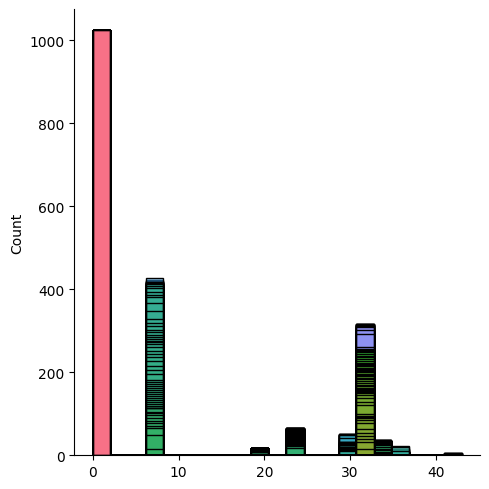

In [2]:
arr = annotations_loader._load_seg_map(results)
print(arr)
import matplotlib.pyplot as plt
import seaborn as sns
sns.displot(arr, legend=False);

In [32]:
arr[arr == 7].shape

(61836,)

In [25]:
np.histogram(arr[arr>0], bins=40)

(array([48427,     0,     0,     0,     0, 61836,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         1906,     0,     0,  7146,     0,     0,     0,     0,  1308,
            0,     0, 27286,  2434,     0,   239,     0,     0,     0,
            0,     0,     0,    35]),
 array([ 1.  ,  2.05,  3.1 ,  4.15,  5.2 ,  6.25,  7.3 ,  8.35,  9.4 ,
        10.45, 11.5 , 12.55, 13.6 , 14.65, 15.7 , 16.75, 17.8 , 18.85,
        19.9 , 20.95, 22.  , 23.05, 24.1 , 25.15, 26.2 , 27.25, 28.3 ,
        29.35, 30.4 , 31.45, 32.5 , 33.55, 34.6 , 35.65, 36.7 , 37.75,
        38.8 , 39.85, 40.9 , 41.95, 43.  ]))